# Machine Learning Models for Breast Cancer Diagnosis

## Assignment understanding

This work based of the idea that it is possible to develop a computer system to help diagnose breast cancer. The system analyzes data derived from images of cell samples, which are taken from a breast lump. Instead of a doctor relying solely on a subjective judgment, this system uses machine learning to classify the cells as cancerous or not.

The primary business objective in any clinical diagnostic setting is to maximize diagnostic accuracy while minimizing errors. Therefore, the goal is to develop a model that serves as a <del>somehow</del> reliable decision support tool for clinicians.

For these purpose we will use the **kNN-classifier algorithm** combined with **hold-out validation** to train a binary classifier. Our process involves tuning the model's hyperparameters by exploring a **range of K-values** to find the configuration that provides the **best possible performance**. Result is measured by use of confusion matrix and key metrics like accuracy, precision, and recall.


## Data understanding

The dataset contains diagnostic test results from 569 patients. It is comprised of 357 samples classified as benign and 212 as malignant. This class distribution is slightly imbalanced, but it is not expected to be a critical issue for this analysis. According to the source, the dataset is clean and contains no missing values.

### Provided specifications

#### Data consists of 32 attributes:
- 1 (ID)
- 1 target variable (diagnosis)
- 30 numeric variables

#### Target variables:
- B (Benign)
- M (Malignant)

#### Measured features (numeric):

| Measurement      | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| Radius           | The mean distance from the center to points on the perimeter.               |
| Texture          | The standard deviation of gray-scale values.                                |
| Perimeter        | The length of the nucleus boundary.                                         |
| Area             | The area of the nucleus.                                                    |
| Smoothness       | A measure of the local variation in radius lengths.                         |
| Compactness      | Calculated as (perimeter² / area) - 1.0.                                    |
| Concavity        | The severity of concave portions of the contour.                            |
| Concave points   | The number of concave portions of the contour.                              |
| Symmetry         | A measure of the nucleus's symmetry.                                        |
| Fractal dimension| An approximation of the "coastline" complexity.                             |


#### For each feature, three values are recorded:


| Value Type | Description                                                                 |
|------------|-----------------------------------------------------------------------------|
| Mean       | The average of all nuclei in the image.                                     |
| SE         | The standard error of the mean for the nuclei.                              |
| Worst      | The mean of the three largest ("worst") values for that feature in the image.|


## Data preparation

### Data import

To ensure a consistent and reliable workflow, we are loading the data from a local folder. This approach makes our project self-contained and independent of network connections, which we found to be a more robust method in previous work.

In [8]:
import numpy as np
import pandas as pd

# 10 available features
features = [
    "radius",
    "texture",
    "perimeter",
    "area",
    "smoothness",
    "compactness",
    "concavity",
    "concave_points",
    "symmetry",
    "fractal_dimension"
]

# 3 versions of each feature available
suffixes = ["mean", "se", "worst"]

# Combining into unique column names
columns = ["ID", "Diagnosis"]
for suffix in suffixes:
    for feature in features:
        columns.append(f"{feature}_{suffix}")

# Use the generated list to load the data into a pandas DataFrame
df = pd.read_csv("./breastCancerData/wdbc.data", header=None, names=columns)

print("\n--- Example Data ---\n")
df.head()



--- Example Data ---



,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Data cleaning and validation

Cleaning data by changing Diagnosis column from a text object to a categorical data type *(others have to be "float" values by default)* and dropping the ID column as it is not a predictive feature.

In [9]:
df["Diagnosis"] = df["Diagnosis"].astype("category")
clean_df = df.drop(columns=['ID'])

We then perform a quick check to validate that the data is clean and ready for use. We inspect the data types and check for any missing values.

In [10]:
summary = clean_df.describe(include="all").T  # Transpose for better readability
summary["dtype"] = df.dtypes # adding data types
summary["missing"] = df.isnull().sum() # adding amount of NaN values
display(summary.T) # display the "transposed summary"

,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,...,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0,569.0
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,14.127292,19.289649,91.969033,654.889104,0.09636,0.104341,0.088799,0.048919,0.181162,...,16.26919,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.07972,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,NaN,6.981,9.71,43.79,143.5,0.05263,0.01938,0.0,0.0,0.106,...,7.93,12.02,50.41,185.2,0.07117,0.02729,0.0,0.0,0.1565,0.05504
25%,NaN,11.7,16.17,75.17,420.3,0.08637,0.06492,0.02956,0.02031,0.1619,...,13.01,21.08,84.11,515.3,0.1166,0.1472,0.1145,0.06493,0.2504,0.07146
50%,NaN,13.37,18.84,86.24,551.1,0.09587,0.09263,0.06154,0.0335,0.1792,...,14.97,25.41,97.66,686.5,0.1313,0.2119,0.2267,0.09993,0.2822,0.08004
75%,NaN,15.78,21.8,104.1,782.7,0.1053,0.1304,0.1307,0.074,0.1957,...,18.79,29.72,125.4,1084.0,0.146,0.3391,0.3829,0.1614,0.3179,0.09208


The summary confirms that there are no missing values and the data types are correct.

### Splitting the Data for Training

Finally, we divide the dataframe into features (X) and the target variable (y). The target variable y is mapped from categorical ('B'/'M') to numeric (0/1) for compatibility with the machine learning model.

Following the principles from our course materials, we split the data into a training set and a testing set using a 70/30 ratio. We use stratify=y to ensure that both the training and testing sets have the same proportion of benign and malignant samples as the original dataset. This is important for handling the slight class imbalance.

In [11]:
from sklearn.model_selection import train_test_split

# Separate the features (inputs) from the target
X = clean_df.drop(columns=['Diagnosis'])
y = clean_df['Diagnosis'].map({'B': 0, 'M': 1})  # Map target to 0 and 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = y)

## Modeling

choose a machine learning method and train the model (+ model validation)
- which method was used?
- which parameters were used?
- what was the performance of the model?

For this task, the k-Nearest Neighbors (kNN) algorithm was used. The parameter k determines how many neighbors are considered to compare to the sample: smaller k values are more sensitive to higher variance, while larger k values create more generalized decision boundaries with higher bias.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # initalizing standard scaler
X_train_scaled = scaler.fit_transform(X_train) # scaling train inputs
X_test_scaled = scaler.fit_transform(X_test) # scaling test inputs

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

results = []

for k in [3, 5, 7, 11]: # trying different values
    kNN = KNeighborsClassifier(n_neighbors = k)
    kNN.fit(X_train_scaled, y_train) # building the classifier

    y_pred = kNN.predict(X_train_scaled)  # predict on training set
    
    acc = accuracy_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)
    rec = recall_score(y_train, y_pred)

    results.append({"k": k, "Accuracy": acc, "Precision": prec, "Recall": rec})

results_df = pd.DataFrame(results) 
results_df

,k,Accuracy,Precision,Recall
0,3,0.979899,0.992958,0.952703
1,5,0.977387,0.992908,0.945946
2,7,0.972362,0.992806,0.932432
3,11,0.969849,0.992754,0.925676


Based on the results, the best choice for the hyperparameter is k = 3, as it provides the highest precision as well as the recall. In the context of cancer diagnosis, recall is especially important, since failing to correctly identify malignant cases can have serious consequences, and having a "false alarm" is more acceptable of the two.


Results for k = 3
Accuracy: 0.9590643274853801
Precision: 0.9830508474576272
Recall: 0.90625


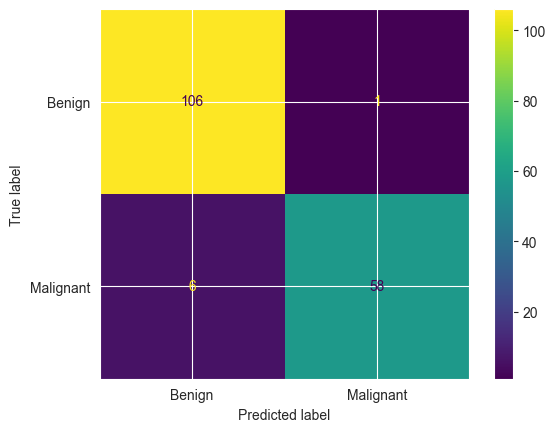

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# choosing the best value for k
k_best = 3
kNN_best = KNeighborsClassifier(n_neighbors = k_best)
kNN_best.fit(X_train_scaled, y_train)

y_pred_best = kNN_best.predict(X_test_scaled) # predict with testing set

print(f"\nResults for k = {k_best}")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant'])
cmd.plot()

## Evaluation

evaluate the model
- How well does the model perform?
- Does it meet the business requirements?

In [15]:
# hello world

## Deployment

johtopaatos / creating a recommendation of how to use the model in practice, or what to do next
- How will the model be used in practice?
- How will the results be communicated?

Model used for educational purposes and due to earlier described training issues is not safe to use in any real business circumstance

In [16]:
# hello world

### Reflection

#### Ai Usage
- for research

#### Team contribution
- who did what

#### Sources
- links & descriptions